In this notbook we'll be looking at the self-blurring and noise-reversal stability metrics for clip-interface spike sorting algorithms (in this case, JRCLUST) as put forth in [this paper](https://doi.org/10.1016/j.jneumeth.2016.02.022) by Alex Barnett, Jeremy Magland, and Leslie Greengard.

You'll need a dataset sorted with [JRCLUST 4](https://github.com/JaneliaSciComp/JRCLUST/releases/tag/v4.0.0), since JRCv3 doesn't expose the functions for computing features without going through the entire detection step again. **I strongly recommend you set `nPeaksFeatures = 1;` in your .prm file before you do the initial sort.**

In [1]:
import os
import os.path as op
import shutil

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize

This next block requires the [MATLAB Engine API for Python](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html). See [this guide](https://www.mathworks.com/help/matlab/matlab_external/install-the-matlab-engine-for-python.html) for how to install it.
I had to run the Anaconda prompt as Administrator in order for `python setup.py install` to run successfully.

[Mind your Python versions](https://www.mathworks.com/help/matlab/matlab_external/system-requirements-for-matlab-engine-for-python.html). For example, I use Python 3.7 and the earliest version of Matlab that supports that is 2019a.

In [2]:
import matlab.engine
try:
    eng = matlab.engine.connect_matlab()
except:
    eng = matlab.engine.start_matlab()

In [3]:
%matplotlib notebook

Define functions to generate confusion matrix and its best permutation.

In [4]:
def confusion_matrix(labels1, labels2):
    """
    Given two sets of labels, return Q where
    Q_{i,j} is the number of spikes in cluster i from the first label set
    and in cluster j in the second label set."""
    m, n = labels1.max() + 1, labels2.max() + 1
    labels1[labels1 < 0] = 0
    labels2[labels2 < 0] = 0

    Q = np.zeros((m, n), dtype=labels1.dtype)
    
    labels1_unique = np.unique(labels1)
    labels2_unique = np.unique(labels2)
    for (i, x) in enumerate(labels1_unique):
        mask1 = (labels1 == x)
        labels2_matches = labels2[mask1]
        for y in np.unique(labels2_matches):
            Q[x, y] = (labels2_matches == y).sum()
            
    return Q

def bpcm(X):
    """Given a confusion matrix X, return its best permutation."""
    m, n = X.shape
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-X) # LSA minimizes the diagonal; we want to maximize it

    Y = X[row_ind, col_ind[:, np.newaxis]]
    if m > n:
        other_rows = np.setdiff1d(np.arange(m), row_ind)
        Z = X[other_rows, :][:, col_ind]
        Y = np.vstack((Y, Z))
        row_ind = np.hstack((row_ind, other_rows))
    elif n > m:
        other_cols = np.setdiff1d(np.arange(n), col_ind)
        Z = X[:, other_cols][row_ind, :]
        Y = np.hstack((Y, Z))
        col_ind = np.hstack((col_ind, other_cols))

    return Y, row_ind, col_ind

Set up the environment. You'll need to change `datadir` and `prefix`.

In [5]:
# this folder contains all your JRC files
datadir = r"F:\boehm-20180802" # CHANGE ME

# everything before ".prm" in your prm file
prefix = "anm420712_20180802_ch0-119bank1_ch120-382bank0_g0_t2.imec.ap" # CHANGE ME

# for pretty plotting
cmap = plt.get_cmap("tab10").colors

In [6]:
# create separate directories for self-blurring and noise-reversal and copy over files
blur_dir = op.join(datadir, "perturbation-tests", "self-blurring")
try:
    os.makedirs(blur_dir)
except FileExistsError:
    pass
except:
    raise

# copy _res.mat to blur_dir
shutil.copy(op.join(datadir, prefix) + "_res.mat", op.join(blur_dir, prefix) + "_res.mat")

# copy _raw.jrc to blur_dir
shutil.copy(op.join(datadir, prefix) + "_raw.jrc", op.join(blur_dir, prefix) + "_raw.jrc")

# copy .prm file to blur_dir
shutil.copy(op.join(datadir, prefix) + ".prm", op.join(blur_dir, prefix) + ".prm")

# write MATLAB function out so we can call it from within this notebook
with open(op.join(blur_dir, "blur_test.m"), "w") as fh:
    print("function success = blur_test()", file=fh)
    print(f"    hCfg = jrclust.Config('{op.join(blur_dir, prefix)}.prm');", file=fh)
    print(f"    hCfg.outputDir = '{blur_dir}';", file=fh)
    print("""    hCfg.testRun = 1;
    hCfg.nPeaksFeatures = 1;
    hCfg.save();
    res = load(hCfg.resFile);
    if res.featuresShape(2) ~= 1
        res.featuresShape(2) = 1;
        res.spikeSites2 = [];
        res.spikesBySite2 = cell(size(res.spikesBySite));
        save(hCfg.resFile, '-struct', 'res', '-v7.3');
    end
    fid = fopen(hCfg.filtFile, 'r');
    spikesFilt = reshape(fread(fid, inf, '*int16'), res.filtShape);
    fclose(fid);
    spikesFilt = jrclust.utils.tryGpuArray(spikesFilt, hCfg.useGPU);
    features1 = jrclust.features.computeFeatures(spikesFilt, hCfg);
    [spikesFilt, features1] = jrclust.utils.tryGather(spikesFilt, features1); %#ok<*ASGLU>
    featuresFid = fopen(hCfg.featuresFile, 'w');
    fwrite(featuresFid, features1, '*single');
    fclose(featuresFid);
    jrc('sort', hCfg.configFile);
    success = 1;
end""", file=fh)

rev_dir = op.join(datadir, "perturbation-tests", "noise-reversal")
try:
    os.makedirs(rev_dir)
except FileExistsError:
    pass
except:
    raise

# copy _res.mat to rev_dir
shutil.copy(op.join(datadir, prefix) + "_res.mat", op.join(rev_dir, prefix) + "_res.mat")

# copy _raw.jrc to rev_dir
shutil.copy(op.join(datadir, prefix) + "_raw.jrc", op.join(rev_dir, prefix) + "_raw.jrc")

# copy .prm file to rev_dir
shutil.copy(op.join(datadir, prefix) + ".prm", op.join(rev_dir, prefix) + ".prm")
with open(op.join(rev_dir, prefix) + ".prm", "a") as fh:
    print("testRun = 1;", file=fh) # so JRCLUST doesn't ask to confirm anything

# write MATLAB function out so we can call it from within this notebook
with open(op.join(rev_dir, "rev_test.m"), "w") as fh:
    print("function success = rev_test()", file=fh)
    print(f"    hCfg = jrclust.Config('{op.join(rev_dir, prefix)}.prm');", file=fh)
    print(f"    hCfg.outputDir = '{rev_dir}';", file=fh)
    print("""    hCfg.testRun = 1;
    hCfg.nPeaksFeatures = 1;
    hCfg.save();
    res = load(hCfg.resFile);
    if res.featuresShape(2) ~= 1
        res.featuresShape(2) = 1;
        res.spikeSites2 = [];
        res.spikesBySite2 = cell(size(res.spikesBySite));
        save(hCfg.resFile, '-struct', 'res', '-v7.3');
    end
    fid = fopen(hCfg.filtFile, 'r');
    spikesFilt = reshape(fread(fid, inf, '*int16'), res.filtShape);
    fclose(fid);
    spikesFilt = jrclust.utils.tryGpuArray(spikesFilt, hCfg.useGPU);
    features1 = jrclust.features.computeFeatures(spikesFilt, hCfg);
    [spikesFilt, features1] = jrclust.utils.tryGather(spikesFilt, features1); %#ok<*ASGLU>
    featuresFid = fopen(hCfg.featuresFile, 'w');
    fwrite(featuresFid, features1, '*single');
    fclose(featuresFid);
    jrc('sort', hCfg.configFile);
    success = 1;
end""", file=fh)

Load in pertinent data.

In [7]:
jrc_file = h5py.File(op.join(datadir, prefix + "_res.mat"))

n_samples_raw, n_channels, n_spikes = jrc_file["rawShape"][()].ravel().astype(np.int32)
n_samples_filt, _, _ = jrc_file["filtShape"][()].ravel().astype(np.int32)
amplitudes = jrc_file["spikeAmps"][()].ravel()
assigns = jrc_file["spikeClusters"][()].ravel().astype(np.int32)
sites = jrc_file["spikeSites"][()].ravel().astype(np.int32) - 1
times = jrc_file["spikeTimes"][()].ravel().astype(np.int64) - 1

jrc_file.close()

assigns[assigns < 0] = 0 # consolidate all garbage clusters
good_clusters = (assigns > 0)
unique_labels = np.unique(assigns[good_clusters])

Load in the raw and filtered spikes as a memory map.

In [8]:
spikes_raw = np.memmap(op.join(datadir, prefix + "_raw.jrc"),
                       dtype=np.int16,
                       mode="r",
                       offset=0,
                       shape=(n_samples_raw, n_channels, n_spikes),
                       order="F")

spikes_filt = np.memmap(op.join(datadir, prefix + "_filt.jrc"),
                        dtype=np.int16,
                        mode="r",
                        offset=0,
                        shape=(n_samples_filt, n_channels, n_spikes),
                        order="F")

## Self-blurring

For a given clip (i.e., spacetime window) $x_i$ assigned to unit $K$, the perturbation $\tilde{x}_i$ is given by

$$\tilde{x}_i := x_i + \gamma(x_j - W_K)$$

where $x_j$ is another clip in unit $K$ and $W_K$ is the mean waveform for unit $K$.

I've set $\gamma = 0.75$ here but it would be worthwhile to experiment with various $0 < \gamma \leq 1$.

In [9]:
eng.cd(blur_dir)

gamma = 0.75
niters = 20
blur_stab = np.zeros((niters, assigns.max() + 1))

for blur_iter in range(niters):
    print(f"iter {blur_iter + 1}/{niters}")

    if "spikes_blurred" in dir():
        del spikes_blurred

    spikes_blurred = np.memmap(op.join(blur_dir, prefix + "_filt.jrc"),
                               dtype=np.int16,
                               mode="w+",
                               offset=0,
                               shape=(n_samples_filt, n_channels, n_spikes),
                               order="F")

    print("\tblurring spikes")
    for k in unique_labels:
        k_mask = (assigns == k)
        Nk = k_mask.sum() # number of spikes in cluster k
        clip_set = spikes_filt[:, :, k_mask].astype(np.float64)
        Wk = clip_set.mean(axis=2) # mean clip
        pi_k = np.random.permutation(Nk)

        blurred_clip_set = clip_set + gamma*(clip_set[:, :, pi_k] - Wk[:, :, np.newaxis])
        spikes_blurred[:, :, k_mask] = blurred_clip_set.astype(spikes_blurred.dtype)

    del spikes_blurred # flush to disk

    # compute features and run JRC sort here
    print("\trecomputing features and sorting")

    res = eng.blur_test()

    if res != 1:
        raise IOError("Matlab engine failed (check Jupyter notebook console for error message)")
    
    # load cluster assignments from perturbed sorting
    jrc_file = h5py.File(op.join(blur_dir, prefix + "_res.mat"))
    blur_assigns = jrc_file["spikeClusters"][()].ravel().astype(np.int32)
    jrc_file.close()

    # compute best permuted confusion matrix of assignments
    print("\tfinding best permutation and computing stability")
    Q, row_ind, col_ind = bpcm(confusion_matrix(assigns, blur_assigns))
    m = min(row_ind.size, col_ind.size)
    nkk = np.array([(assigns == k).sum() for k in row_ind[:m]])
    nkl = np.array([(blur_assigns == k).sum() for k in col_ind[:m]])
    blur_stab[blur_iter, row_ind[:m]] = 2 * np.diag(Q) / (nkk + nkl)
    
    # backup perturbed features for later inspection
    shutil.copy2(op.join(blur_dir, prefix + "_features.jrc"), op.join(blur_dir, prefix + f"_features{blur_iter}.jrc"))
    
np.save(op.join(blur_dir, "stab.npy"), blur_stab)

iter 1/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 2/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 3/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 4/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 5/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 6/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 7/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 8/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
iter 9/20
	blurring spikes
	recomputing features and sorting
	finding best permutation and computing stability
i

Now we load up the most recently computed self-blurred traces.

In [10]:
spikes_blurred = np.memmap(op.join(blur_dir, prefix + "_filt.jrc"),
                           dtype=np.int16,
                           mode="r",
                           offset=0,
                           shape=(n_samples_filt, n_channels, n_spikes),
                           order="F")

Here we take a look at the blurring effect on a random set of traces.

<IPython.core.display.Javascript object>


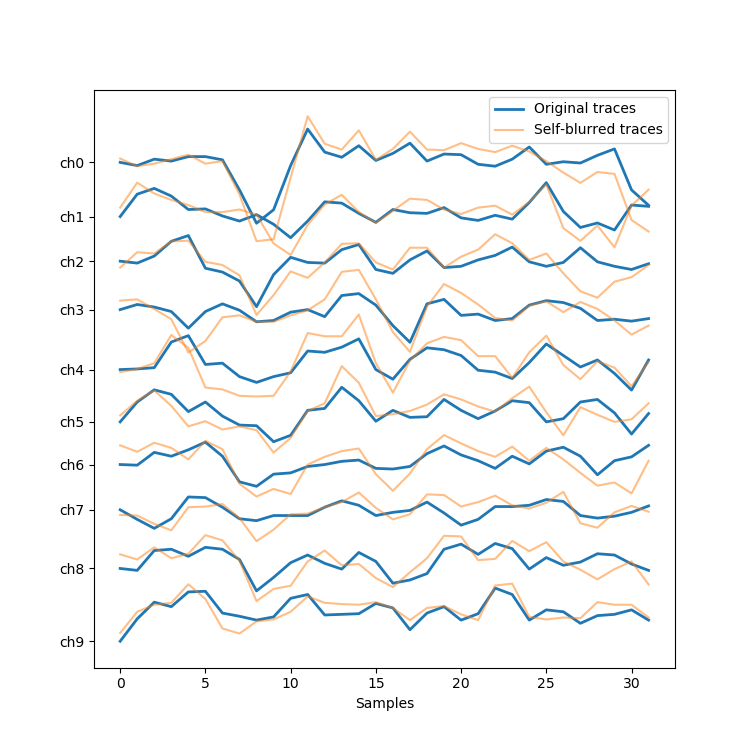

In [11]:
m = np.random.choice(n_spikes, 1)[0]
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))

scale_factor = 4*np.std(spikes_filt[:, :, m])

# plot original traces
lines = ax.plot(spikes_filt[:, :, m] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[0], linewidth=2)
lines[0].set_label("Original traces")

# plot self-blurred traces
lines = ax.plot(spikes_blurred[:, :, m] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[1], alpha=0.5)
lines[0].set_label("Self-blurred traces")

ax.set_yticks(spikes_filt[0, :, m] - scale_factor*np.arange(spikes_filt.shape[1]))
ax.set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax.set_xlabel("Samples")
ax.legend()

Let's look at some summary statistics around our stability metrics.

In [12]:
blur_stats = pd.DataFrame(blur_stab, columns=["noise unit"] + [f"unit {i}" for i in range(1, assigns.max() + 1)])
blur_summary = blur_stats.describe()

# we say the "best" unit is the one for which the mean stability score is largest
blur_best = blur_summary.loc["mean", :].idxmax()

# similarly, the "worst" unit is the one for which the mean stability score is smallest
blur_worst = blur_summary.loc["mean", :].idxmin()

# the "largest" unit here is simply the unit with the largest standard deviation
blur_largest = blur_summary.loc["std", :].idxmax()

blur_summary

noise unit     unit 1     unit 2     unit 3     unit 4     unit 5  \
count   20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean     0.632711   0.423478   0.408941   0.253906   0.214777   0.696872   
std      0.012790   0.148869   0.121353   0.196048   0.167146   0.115738   
min      0.612880   0.000000   0.211268   0.000000   0.000000   0.429783   
25%      0.623900   0.386013   0.292034   0.006912   0.081258   0.616396   
50%      0.628744   0.449343   0.427908   0.299461   0.178906   0.714759   
75%      0.643698   0.518635   0.498255   0.422854   0.362480   0.790147   
max      0.659136   0.634291   0.586031   0.544828   0.520942   0.837259   

          unit 6     unit 7     unit 8     unit 9  ...   unit 900   unit 901  \
count  20.000000  20.000000  20.000000  20.000000  ...  20.000000  20.000000   
mean    0.315773   0.636098   0.914829   0.996343  ...   0.869533   0.986200   
std     0.208294   0.068743   0.099638   0.002701  ...   0.097339   0.021388   
min     0.000000   0.466997   0.696277   0.987797  ...   0.673755   0.932787   
25%     0.125660   0.629100   0.874181   0.996128  ...   0.795075   0.985883   
50%     0.374037   0.656179   0.951403   0.997140  ...   0.882884   0.997772   
75%     0.494347   0.681005   0.998083   0.997509  ...   0.954300   0.998464   
max     0.612254   0.704589   0.999567   0.999153  ...   0.970565   0.999324   

        unit 902   unit 903   unit 904   unit 905   unit 906   unit 907  \
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000   
mean    0.981213   0.732333   0.140645   0.931610   0.253358   0.875664   
std     0.010452   0.055221   0.165208   0.066153   0.264913   0.132663   
min     0.948190   0.597674   0.000000   0.736651   0.000000   0.554442   
25%     0.977602   0.717333   0.000000   0.929840   0.000000   0.819650   
50%     0.983461   0.760917   0.096130   0.958704   0.173502   0.883007   
75%     0.986575   0.768574   0.269528   0.969628   0.502111   0.991083   
max     0.993160   0.778474   0.562887   0.977920   0.665455   0.993468   

        unit 908   unit 909  
count  20.000000  20.000000  
mean    0.946166   0.032140  
std     0.007691   0.083925  
min     0.926735   0.000000  
25%     0.940562   0.000000  
50%     0.947757   0.000951  
75%     0.951812   0.009089  
max     0.955928   0.293706  

[8 rows x 910 columns]

<IPython.core.display.Javascript object>


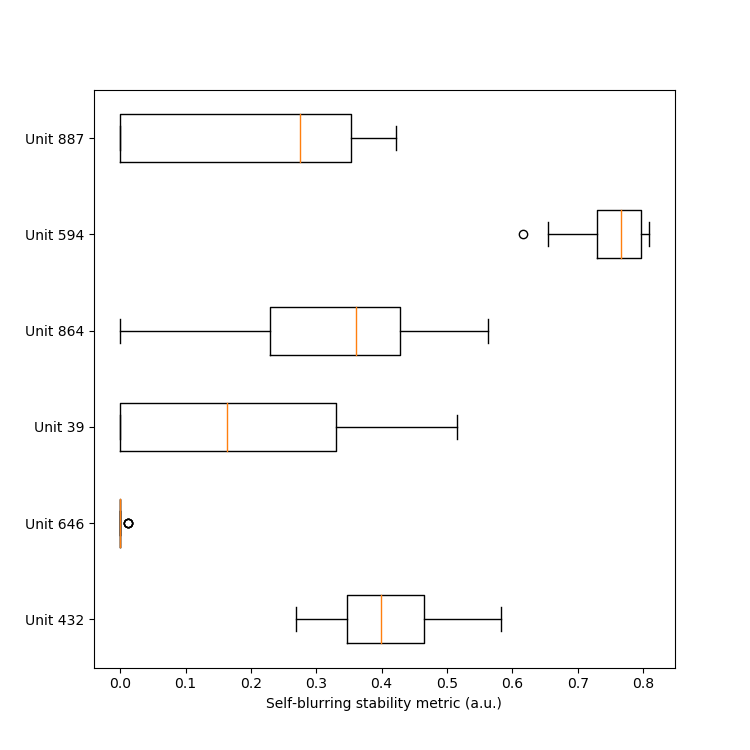

<IPython.core.display.Javascript object>


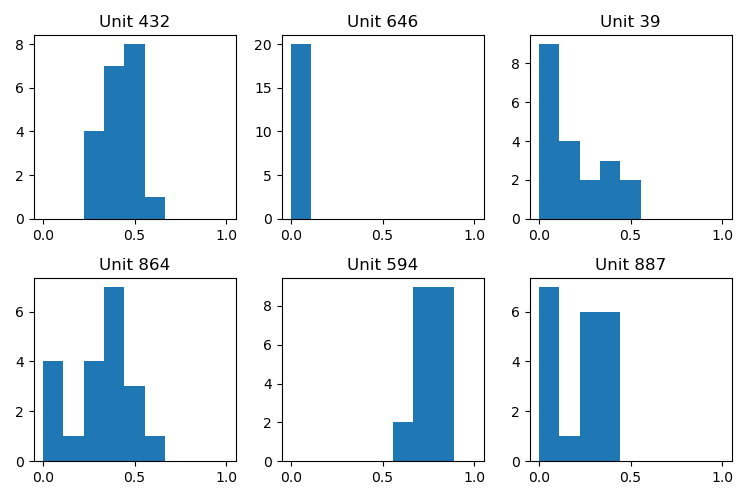

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))

# randomly select 6 units to see how they did
unseen = list(set(blur_stats.columns).difference([blur_best, blur_worst, blur_largest]))
choice1 = np.random.choice(unseen); unseen.remove(choice1)
choice2 = np.random.choice(unseen); unseen.remove(choice2)
choice3 = np.random.choice(unseen); unseen.remove(choice3)
choice4 = np.random.choice(unseen); unseen.remove(choice4)
choice5 = np.random.choice(unseen); unseen.remove(choice5)
choice6 = np.random.choice(unseen)

ax.boxplot([blur_stats.loc[:, choice1],
            blur_stats.loc[:, choice2],
            blur_stats.loc[:, choice3],
            blur_stats.loc[:, choice4],
            blur_stats.loc[:, choice5],
            blur_stats.loc[:, choice6]], vert=False)
ax.set_yticklabels([choice1.title(), choice2.title(), choice3.title(),
                    choice4.title(), choice5.title(), choice6.title()])
ax.set_xlabel("Self-blurring stability metric (a.u.)")

fig, ax = plt.subplots(2, 3, figsize=(7.5, 5))
ax[0, 0].hist(blur_stats.loc[:, choice1], bins=np.linspace(0, 1, 10))
ax[0, 0].set_title(choice1.title())

ax[0, 1].hist(blur_stats.loc[:, choice2], bins=np.linspace(0, 1, 10))
ax[0, 1].set_title(choice2.title())

ax[0, 2].hist(blur_stats.loc[:, choice3], bins=np.linspace(0, 1, 10))
ax[0, 2].set_title(choice3.title())

ax[1, 0].hist(blur_stats.loc[:, choice4], bins=np.linspace(0, 1, 10))
ax[1, 0].set_title(choice4.title())

ax[1, 1].hist(blur_stats.loc[:, choice5], bins=np.linspace(0, 1, 10))
ax[1, 1].set_title(choice5.title())

ax[1, 2].hist(blur_stats.loc[:, choice6], bins=np.linspace(0, 1, 10))
ax[1, 2].set_title(choice6.title())
fig.tight_layout()

Next, let's look at a scatterplot of the means and standard deviations of the scores.

<IPython.core.display.Javascript object>


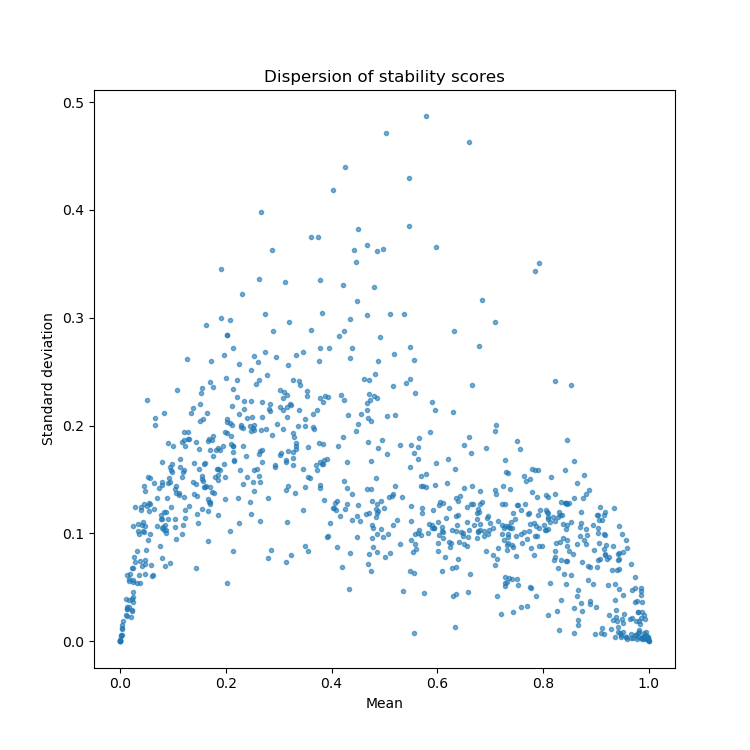

Text(0.5, 1.0, 'Dispersion of stability scores')

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.plot(blur_summary.loc["mean", :], blur_summary.loc["std", :], '.', alpha=0.6)
ax.set_xlabel("Mean")
ax.set_ylabel("Standard deviation")
ax.set_title("Dispersion of stability scores")

Finally, we'll examine how the best, worst, and most dispersed units actually look in the data.

First, the most stable unit.

<IPython.core.display.Javascript object>


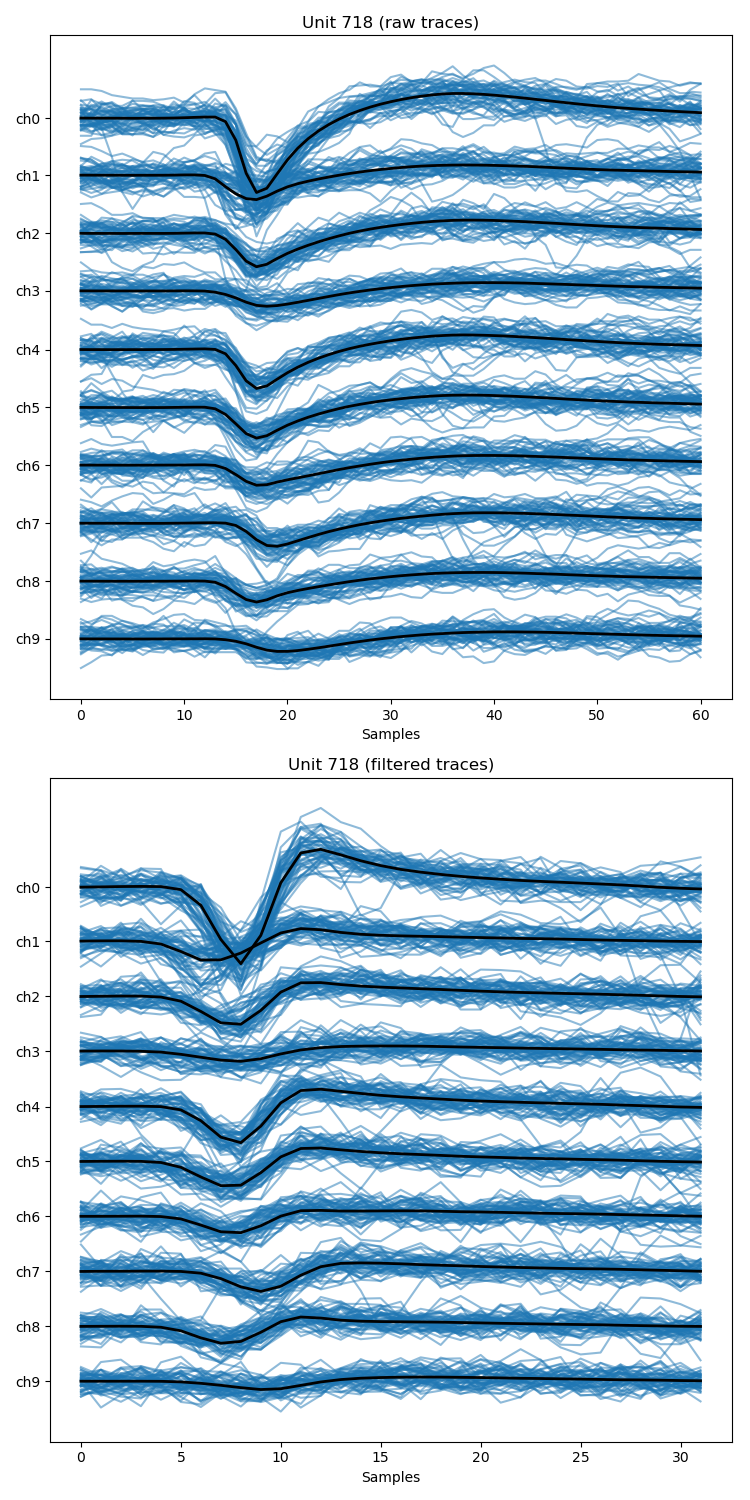

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))

best_mask = np.where(assigns == int(blur_best.replace("unit ", "")))[0]

best_raw = spikes_raw[:, :, best_mask] - spikes_raw[:, :, best_mask].mean(axis=0)[np.newaxis, :, :]
best_raw_mean = best_raw.mean(axis=2)

scale_factor = 4*np.std(best_raw)

for k in np.random.choice(best_raw.shape[2], 50):
    ax[0].plot(best_raw[:, :, k] - scale_factor*np.arange(spikes_raw.shape[1]), color=cmap[0], alpha=0.5)
ax[0].plot(best_raw_mean - scale_factor*np.arange(spikes_raw.shape[1]), color='k', linewidth=2)
ax[0].set_yticks(best_raw_mean[0, :] - scale_factor*np.arange(spikes_raw.shape[1]))
ax[0].set_yticklabels([f"ch{i}" for i in range(spikes_raw.shape[1])])
ax[0].set_xlabel("Samples")
ax[0].set_title(f"{blur_best.title()} (raw traces)")

best_filt = spikes_filt[:, :, best_mask] - spikes_filt[:, :, best_mask].mean(axis=0)[np.newaxis, :, :]
best_filt_mean = best_filt.mean(axis=2)

scale_factor = 4*np.std(best_filt)

for k in np.random.choice(best_filt.shape[2], 50):
    ax[1].plot(best_filt[:, :, k] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[0], alpha=0.5)
ax[1].plot(best_filt_mean - scale_factor*np.arange(spikes_filt.shape[1]), color='k', linewidth=2)
ax[1].set_yticks(best_filt_mean[0, :] - scale_factor*np.arange(spikes_filt.shape[1]))
ax[1].set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax[1].set_xlabel("Samples")
ax[1].set_title(f"{blur_best.title()} (filtered traces)")
fig.tight_layout()

Next, the least stable unit.

<IPython.core.display.Javascript object>


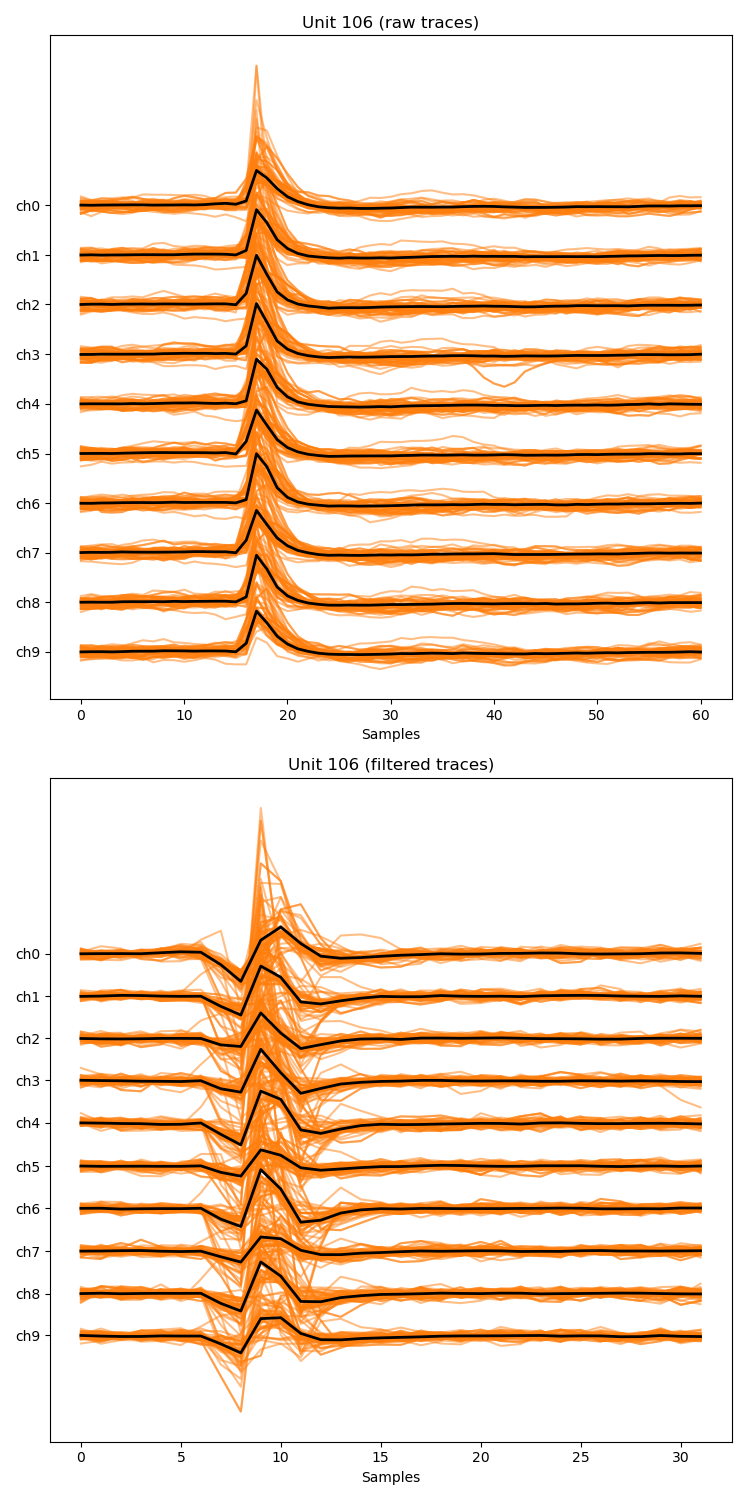

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))

worst_mask = np.where(assigns == int(blur_worst.replace("unit ", "")))[0]

worst_raw = spikes_raw[:, :, worst_mask] - spikes_raw[:, :, worst_mask].mean(axis=0)[np.newaxis, :, :]
worst_raw_mean = worst_raw.mean(axis=2)

scale_factor = 4*np.std(worst_raw)

for k in np.random.choice(worst_raw.shape[2], 50):
    ax[0].plot(worst_raw[:, :, k] - scale_factor*np.arange(spikes_raw.shape[1]), color=cmap[1], alpha=0.5)
ax[0].plot(worst_raw_mean - scale_factor*np.arange(spikes_raw.shape[1]), color='k', linewidth=2)
ax[0].set_yticks(worst_raw_mean[0, :] - scale_factor*np.arange(spikes_raw.shape[1]))
ax[0].set_yticklabels([f"ch{i}" for i in range(spikes_raw.shape[1])])
ax[0].set_xlabel("Samples")
ax[0].set_title(f"{blur_worst.title()} (raw traces)")

worst_filt = spikes_filt[:, :, worst_mask] - spikes_filt[:, :, worst_mask].mean(axis=0)[np.newaxis, :, :]
worst_filt_mean = worst_filt.mean(axis=2)

scale_factor = 4*np.std(worst_filt)

for k in np.random.choice(worst_filt.shape[2], 50):
    ax[1].plot(worst_filt[:, :, k] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[1], alpha=0.5)
ax[1].plot(worst_filt_mean - scale_factor*np.arange(spikes_filt.shape[1]), color='k', linewidth=2)
ax[1].set_yticks(worst_filt_mean[0, :] - scale_factor*np.arange(spikes_filt.shape[1]))
ax[1].set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax[1].set_xlabel("Samples")
ax[1].set_title(f"{blur_worst.title()} (filtered traces)")

fig.tight_layout()

Finally, the unit with the largest standard deviation.

<IPython.core.display.Javascript object>


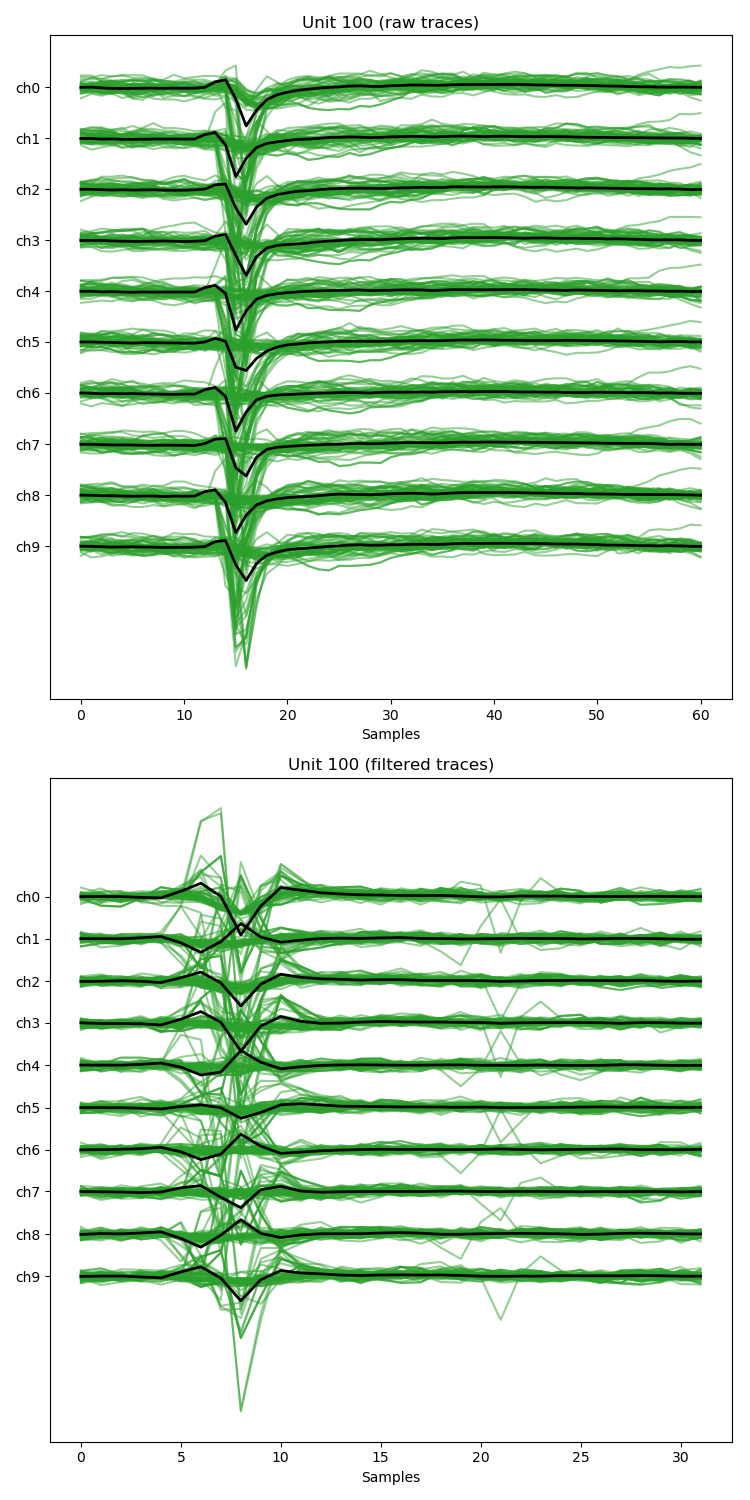

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))

largest_mask = np.where(assigns == int(blur_largest.replace("unit ", "")))[0]

largest_raw = spikes_raw[:, :, largest_mask] - spikes_raw[:, :, largest_mask].mean(axis=0)[np.newaxis, :, :]
largest_raw_mean = largest_raw.mean(axis=2)

scale_factor = 4*np.std(largest_raw)

for k in np.random.choice(largest_raw.shape[2], 50):
    ax[0].plot(largest_raw[:, :, k] - scale_factor*np.arange(spikes_raw.shape[1]), color=cmap[2], alpha=0.5)
ax[0].plot(largest_raw_mean - scale_factor*np.arange(spikes_raw.shape[1]), color='k', linewidth=2)
ax[0].set_yticks(largest_raw_mean[0, :] - scale_factor*np.arange(spikes_raw.shape[1]))
ax[0].set_yticklabels([f"ch{i}" for i in range(spikes_raw.shape[1])])
ax[0].set_xlabel("Samples")
ax[0].set_title(f"{blur_largest.title()} (raw traces)")

largest_filt = spikes_filt[:, :, largest_mask] - spikes_filt[:, :, largest_mask].mean(axis=0)[np.newaxis, :, :]
largest_filt_mean = largest_filt.mean(axis=2)

scale_factor = 4*np.std(largest_filt)

for k in np.random.choice(largest_filt.shape[2], 50):
    ax[1].plot(largest_filt[:, :, k] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[2], alpha=0.5)
ax[1].plot(largest_filt_mean - scale_factor*np.arange(spikes_filt.shape[1]), color='k', linewidth=2)
ax[1].set_yticks(largest_filt_mean[0, :] - scale_factor*np.arange(spikes_filt.shape[1]))
ax[1].set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax[1].set_xlabel("Samples")
ax[1].set_title(f"{blur_largest.title()} (filtered traces)")

fig.tight_layout()

## Noise-reversal

For a given clip (i.e., spacetime window) $x_i$ assigned to unit $K$, the perturbation $\tilde{x}_i$ is given by

$$\tilde{x}_i := 2W_K - xi = W_K - (x_i - W_K)$$

where $x_j$ is another clip in unit $K$ and $W_K$ is the mean waveform for unit $K$; i.e., the "noise" $(x_i - W_K)$ is subtracted off of $W_K$ rather than added on.

In [18]:
eng.cd(rev_dir)
rev_stab = np.zeros((assigns.max() + 1), )

spikes_rev = np.memmap(op.join(rev_dir, prefix + "_filt.jrc"),
                       dtype=np.int16,
                       mode="w+",
                       offset=0,
                       shape=(n_samples_filt, n_channels, n_spikes),
                       order="F")

print("noise-reversing spikes")
for k in unique_labels:
    k_mask = (assigns == k)
    Nk = k_mask.sum() # number of spikes in cluster k
    clip_set = spikes_filt[:, :, k_mask].astype(np.float64)
    Wk = clip_set.mean(axis=2) # mean clip

    revd_clip_set = 2*Wk[:, :, np.newaxis] - clip_set
    spikes_rev[:, :, k_mask] = revd_clip_set.astype(spikes_rev.dtype)

del spikes_rev # flush to disk

# compute features and run JRC sort here
print("\trecomputing features and sorting")
res = eng.rev_test()

if res != 1:
    raise IOError("Matlab engine failed (check Jupyter notebook console for error message)")

# load cluster assignments from perturbed sorting
jrc_file = h5py.File(op.join(rev_dir, prefix + "_res.mat"))
rev_assigns = jrc_file["spikeClusters"][()].ravel().astype(np.int32)
jrc_file.close()

# compute best permuted confusion matrix of assignments
print("\tfinding best permutation and computing stability")
Q, row_ind, col_ind = bpcm(confusion_matrix(assigns, rev_assigns))
m = min(row_ind.size, col_ind.size)
nkk = np.array([(assigns == k).sum() for k in row_ind[:m]])
nkl = np.array([(rev_assigns == k).sum() for k in col_ind[:m]])
rev_stab[row_ind[:m]] = 2 * np.diag(Q) / (nkk + nkl)

np.save(op.join(rev_dir, "stab.npy"), rev_stab)

noise-reversing spikes
	recomputing features and sorting
	finding best permutation and computing stability


Now we load up the most recently computed noise-reversed traces.

In [19]:
spikes_revd = np.memmap(op.join(rev_dir, prefix + "_filt.jrc"),
                        dtype=np.int16,
                        mode="r",
                        offset=0,
                        shape=(n_samples_filt, n_channels, n_spikes),
                        order="F")

Here we take a look at the noise-reversing effect on a random set of traces.

<IPython.core.display.Javascript object>


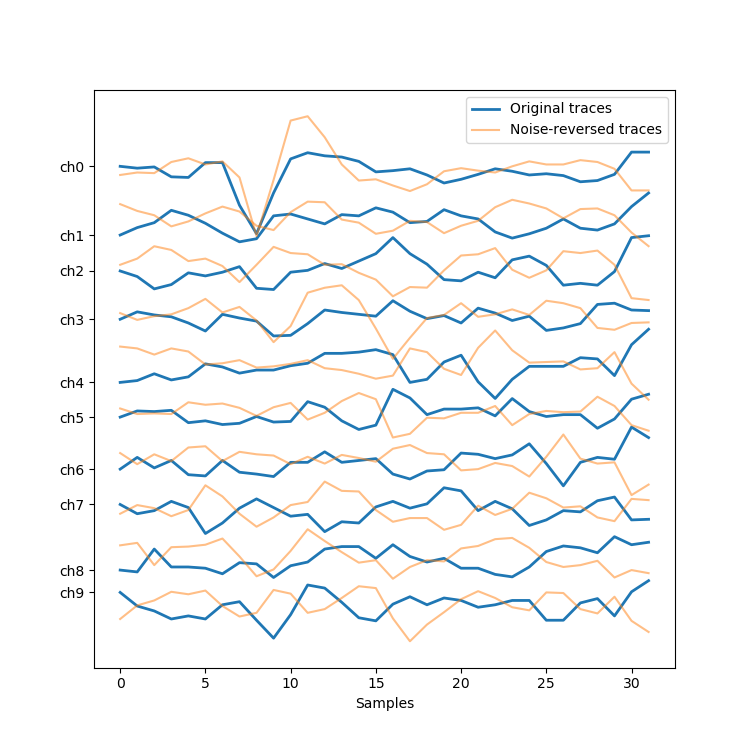

In [20]:
m = np.random.choice(n_spikes, 1)[0]
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))

scale_factor = 4*np.std(spikes_filt[:, :, m])

# plot original traces
lines = ax.plot(spikes_filt[:, :, m] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[0], linewidth=2)
lines[0].set_label("Original traces")

# plot noise-reversed traces
lines = ax.plot(spikes_revd[:, :, m] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[1], alpha=0.5)
lines[0].set_label("Noise-reversed traces")

ax.set_yticks(spikes_filt[0, :, m] - scale_factor*np.arange(spikes_filt.shape[1]))
ax.set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax.set_xlabel("Samples")
ax.legend()

In this case, since there's only one run, we can examine the distribution over all units of the stability scores directly.

<IPython.core.display.Javascript object>


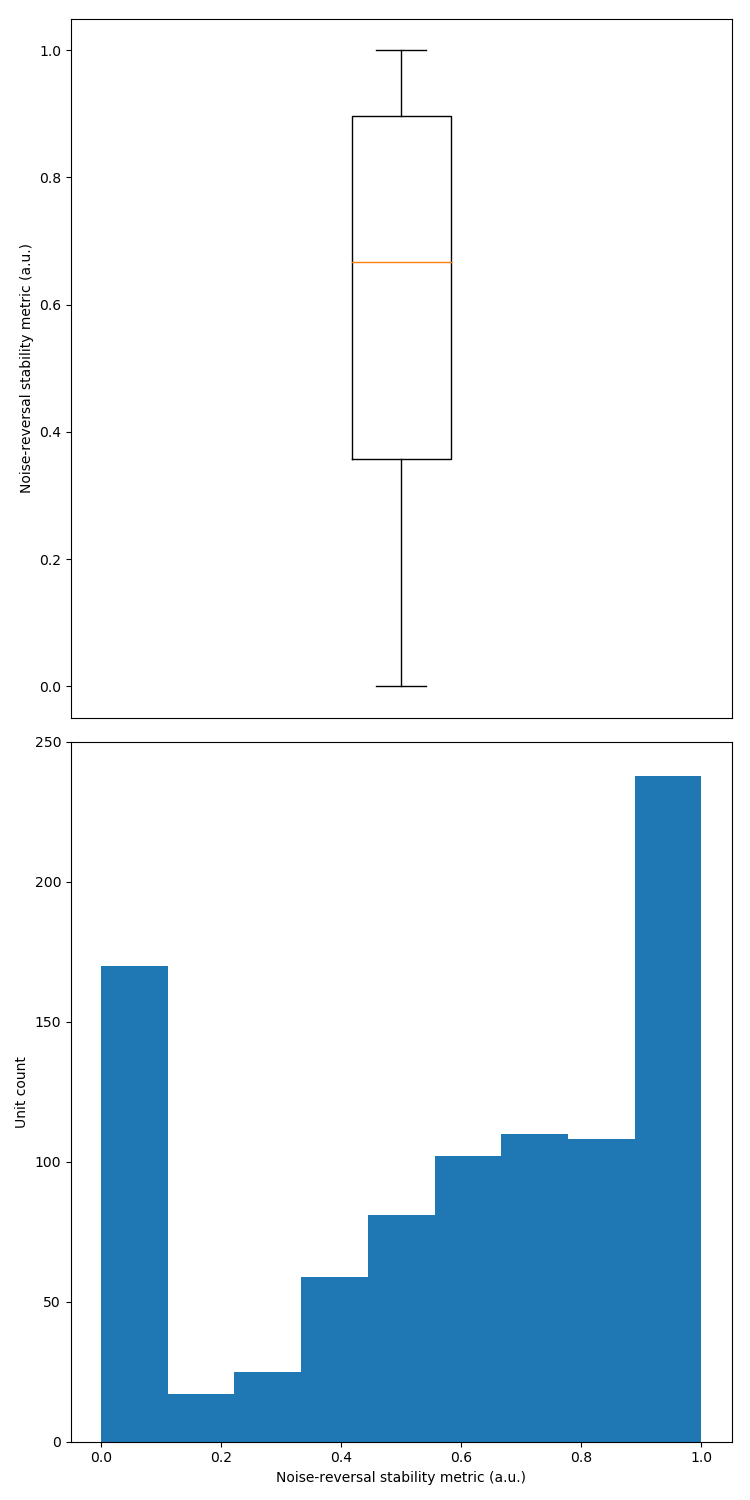

In [21]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))
ax[0].boxplot(rev_stab, vert=True)
ax[0].set_xticks([])
ax[0].set_ylabel("Noise-reversal stability metric (a.u.)")

ax[1].hist(rev_stab, bins=np.linspace(0, 1, 10))
ax[1].set_xlabel("Noise-reversal stability metric (a.u.)")
ax[1].set_ylabel("Unit count")

fig.tight_layout()

Finally, we'll examine how the best, worst, and most dispersed units actually look in the data.

In [22]:
rev_best = rev_stab.argmax()
rev_worst = rev_stab.argmin()
rev_median = np.abs(rev_stab - np.median(rev_stab)).argmin()

First, the most stable unit.

<IPython.core.display.Javascript object>


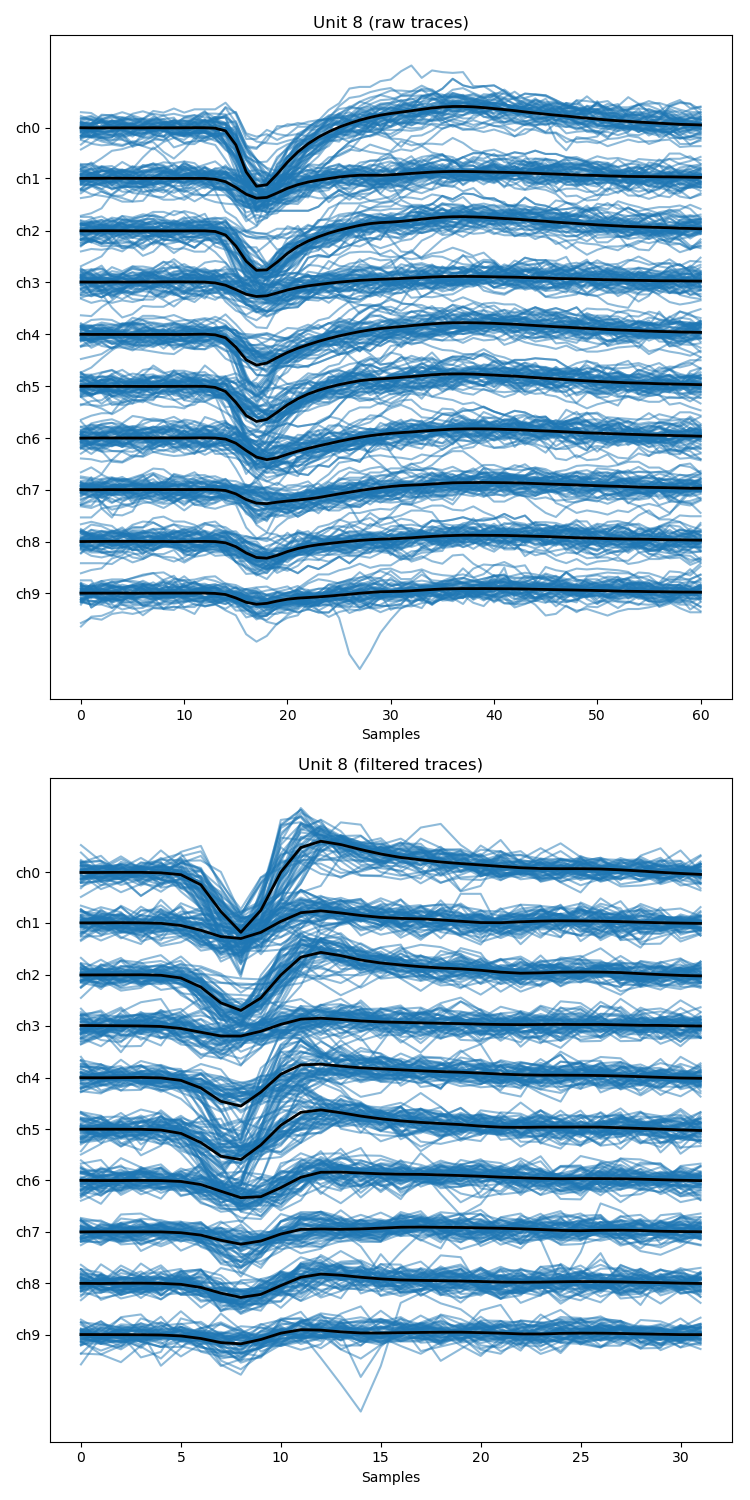

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))

best_mask = np.where(assigns == rev_best)[0]

best_raw = spikes_raw[:, :, best_mask] - spikes_raw[:, :, best_mask].mean(axis=0)[np.newaxis, :, :]
best_raw_mean = best_raw.mean(axis=2)

scale_factor = 4*np.std(best_raw)

for k in np.random.choice(best_raw.shape[2], 50):
    ax[0].plot(best_raw[:, :, k] - scale_factor*np.arange(spikes_raw.shape[1]), color=cmap[0], alpha=0.5)
ax[0].plot(best_raw_mean - scale_factor*np.arange(spikes_raw.shape[1]), color='k', linewidth=2)
ax[0].set_yticks(best_raw_mean[0, :] - scale_factor*np.arange(spikes_raw.shape[1]))
ax[0].set_yticklabels([f"ch{i}" for i in range(spikes_raw.shape[1])])
ax[0].set_xlabel("Samples")
ax[0].set_title(f"Unit {rev_best} (raw traces)")

best_filt = spikes_filt[:, :, best_mask] - spikes_filt[:, :, best_mask].mean(axis=0)[np.newaxis, :, :]
best_filt_mean = best_filt.mean(axis=2)

scale_factor = 4*np.std(best_filt)

for k in np.random.choice(best_filt.shape[2], 50):
    ax[1].plot(best_filt[:, :, k] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[0], alpha=0.5)
ax[1].plot(best_filt_mean - scale_factor*np.arange(spikes_filt.shape[1]), color='k', linewidth=2)
ax[1].set_yticks(best_filt_mean[0, :] - scale_factor*np.arange(spikes_filt.shape[1]))
ax[1].set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax[1].set_xlabel("Samples")
ax[1].set_title(f"Unit {rev_best} (filtered traces)")
fig.tight_layout()

Next, the least stable unit.

<IPython.core.display.Javascript object>


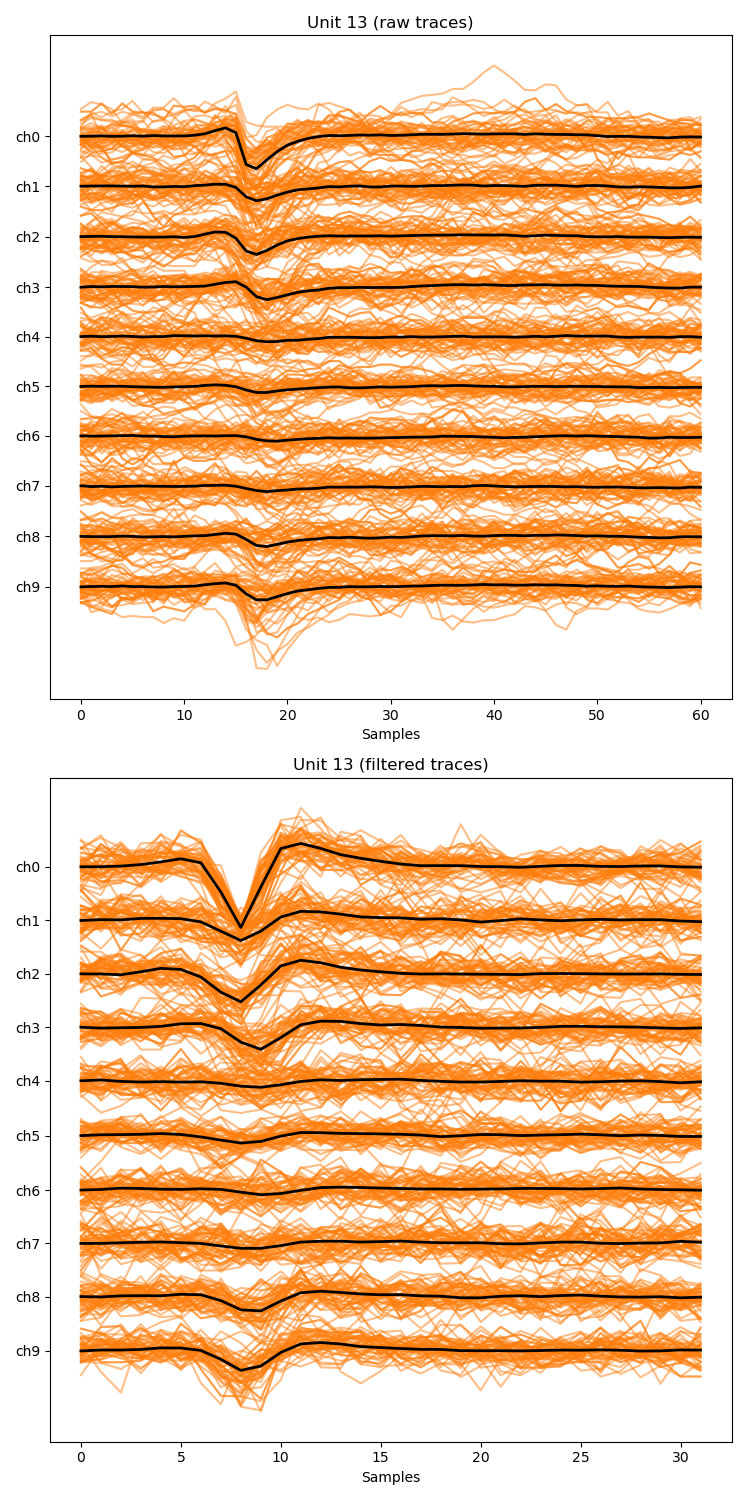

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))

worst_mask = np.where(assigns == rev_worst)[0]

worst_raw = spikes_raw[:, :, worst_mask] - spikes_raw[:, :, worst_mask].mean(axis=0)[np.newaxis, :, :]
worst_raw_mean = worst_raw.mean(axis=2)

scale_factor = 4*np.std(worst_raw)

for k in np.random.choice(worst_raw.shape[2], 50):
    ax[0].plot(worst_raw[:, :, k] - scale_factor*np.arange(spikes_raw.shape[1]), color=cmap[1], alpha=0.5)
ax[0].plot(worst_raw_mean - scale_factor*np.arange(spikes_raw.shape[1]), color='k', linewidth=2)
ax[0].set_yticks(worst_raw_mean[0, :] - scale_factor*np.arange(spikes_raw.shape[1]))
ax[0].set_yticklabels([f"ch{i}" for i in range(spikes_raw.shape[1])])
ax[0].set_xlabel("Samples")
ax[0].set_title(f"Unit {rev_worst} (raw traces)")

worst_filt = spikes_filt[:, :, worst_mask] - spikes_filt[:, :, worst_mask].mean(axis=0)[np.newaxis, :, :]
worst_filt_mean = worst_filt.mean(axis=2)

scale_factor = 4*np.std(worst_filt)

for k in np.random.choice(worst_filt.shape[2], 50):
    ax[1].plot(worst_filt[:, :, k] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[1], alpha=0.5)
ax[1].plot(worst_filt_mean - scale_factor*np.arange(spikes_filt.shape[1]), color='k', linewidth=2)
ax[1].set_yticks(worst_filt_mean[0, :] - scale_factor*np.arange(spikes_filt.shape[1]))
ax[1].set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax[1].set_xlabel("Samples")
ax[1].set_title(f"Unit {rev_worst} (filtered traces)")
fig.tight_layout()

Finally, the most average unit.

<IPython.core.display.Javascript object>


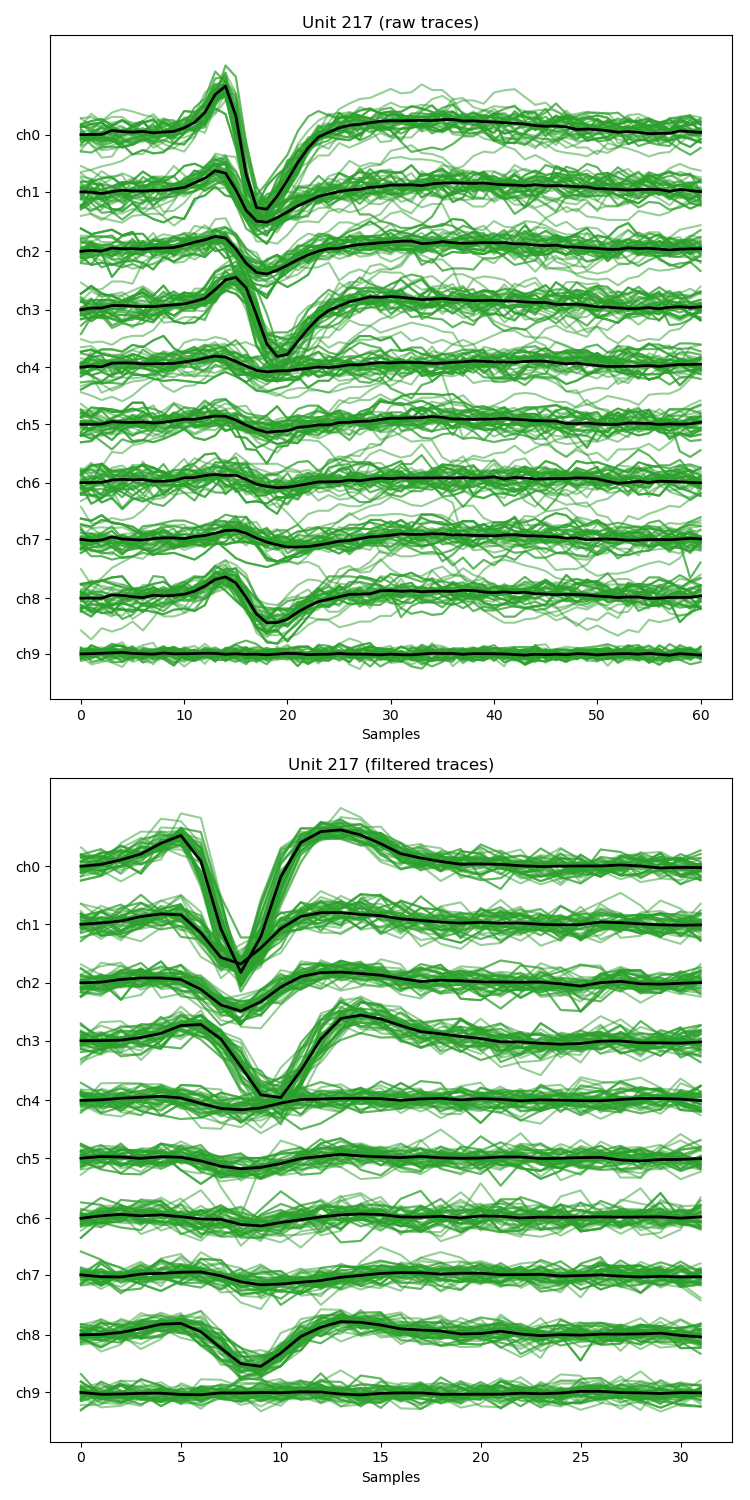

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(7.5, 15))

median_mask = np.where(assigns == rev_median)[0]

median_raw = spikes_raw[:, :, median_mask] - spikes_raw[:, :, median_mask].mean(axis=0)[np.newaxis, :, :]
median_raw_mean = median_raw.mean(axis=2)

scale_factor = 4*np.std(median_raw)

for k in np.random.choice(median_raw.shape[2], 50):
    ax[0].plot(median_raw[:, :, k] - scale_factor*np.arange(spikes_raw.shape[1]), color=cmap[2], alpha=0.5)
ax[0].plot(median_raw_mean - scale_factor*np.arange(spikes_raw.shape[1]), color='k', linewidth=2)
ax[0].set_yticks(median_raw_mean[0, :] - scale_factor*np.arange(spikes_raw.shape[1]))
ax[0].set_yticklabels([f"ch{i}" for i in range(spikes_raw.shape[1])])
ax[0].set_xlabel("Samples")
ax[0].set_title(f"Unit {rev_median} (raw traces)")

median_filt = spikes_filt[:, :, median_mask] - spikes_filt[:, :, median_mask].mean(axis=0)[np.newaxis, :, :]
median_filt_mean = median_filt.mean(axis=2)

scale_factor = 4*np.std(median_filt)

for k in np.random.choice(median_filt.shape[2], 50):
    ax[1].plot(median_filt[:, :, k] - scale_factor*np.arange(spikes_filt.shape[1]), color=cmap[2], alpha=0.5)
ax[1].plot(median_filt_mean - scale_factor*np.arange(spikes_filt.shape[1]), color='k', linewidth=2)
ax[1].set_yticks(median_filt_mean[0, :] - scale_factor*np.arange(spikes_filt.shape[1]))
ax[1].set_yticklabels([f"ch{i}" for i in range(spikes_filt.shape[1])])
ax[1].set_xlabel("Samples")
ax[1].set_title(f"Unit {rev_median} (filtered traces)")
fig.tight_layout()